In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import pyspark.pandas as ps
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from waymo_open_dataset.protos import scenario_pb2 

spark = SparkSession.builder.appName("echipa team").getOrCreate()
sc = spark.sparkContext

2022-12-15 18:03:48.043513: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/gurobi1000/linux64/lib
2022-12-15 18:03:48.043532: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


22/12/15 18:03:52 WARN Utils: Your hostname, teofil-ubuntu resolves to a loopback address: 127.0.1.1; using 192.168.100.4 instead (on interface wlp4s0)
22/12/15 18:03:52 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/15 18:03:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
DIRNAME = 'training'
scenarios = []
for filename in list(os.listdir(DIRNAME))[:5]:
    filepath = os.path.join(DIRNAME, filename)
    dataset = tf.data.TFRecordDataset(filepath)
    for data in dataset:
        proto_string = data.numpy()
        proto = scenario_pb2.Scenario()
        proto.ParseFromString(proto_string)

        scenarios.append(proto)

2022-12-15 18:04:12.583497: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 18:04:12.583791: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/gurobi1000/linux64/lib
2022-12-15 18:04:12.583904: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/gurobi1000/linux64/lib
2022-12-15 18:04:12.583981: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory;

In [4]:
len(scenarios), sum([len(scenario.tracks) for scenario in scenarios])

(2412, 158410)

/home/teofil/anaconda3/lib/python3.9/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


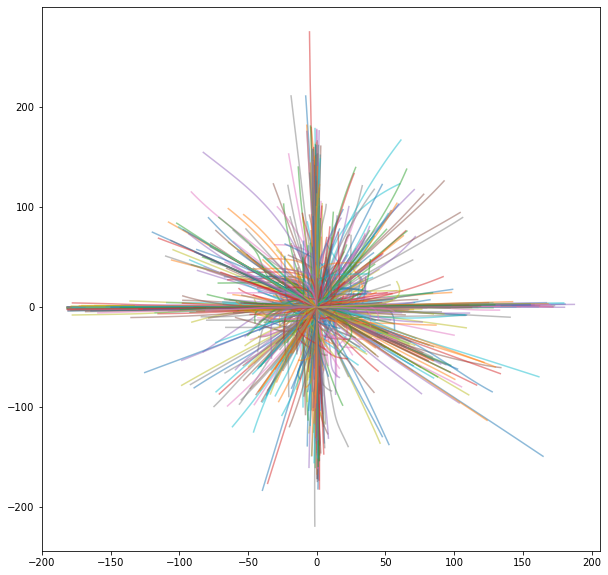

In [5]:
# track = scenarios[0].tracks[0]
def state_to_array(track, column):
    return np.array(
        [getattr(state, column) for state in track.states],
        dtype='float'
    )
        
state_columns = [
    'center_x', 
    'center_y', 
    'center_z', 
    'heading', 
    'velocity_x', 
    'velocity_y', 
    'valid'
]
columns = ['scenario_id', 'track_id', 'object_type'] + state_columns
track_entries = []

fig, ax = plt.subplots(1,1, figsize=(10,10))
for scenario in scenarios:
    track = scenario.tracks[scenario.sdc_track_index]
    # for track in scenario.tracks:
    entry = [
        scenario.scenario_id, 
        track.id, 
        track.object_type
    ]
    coords = []
    for column in state_columns:
        arr = state_to_array(track, column)
        if column in ['center_x','center_y', 'center_z']:
            arr -= arr[0]
            coords.append(arr)
        
        entry.append(arr.tolist())
    ax.plot(coords[0], coords[1], alpha=.5)
    track_entries.append(entry)
psdf = ps.DataFrame(track_entries, columns=columns)
sdf = psdf.to_spark() #index_col='index'

In [7]:


def plot_hist(sdf, column, buckets):
  hist = sdf.select(
    column
  ).rdd.flatMap(
    lambda x: x
  ).flatMap(lambda x: [i for i in x]).histogram(buckets)
  values, counts = hist
  # pairs = list(zip(counts, values))
  # pairs.sort(key=lambda p: p[1])
  # counts = [pair[0] for pair in pairs]
  # values = [pair[1] for pair in pairs]
  plt.bar(x=values[:-1], height=counts, width=np.diff(values), align='edge', log=True);
  # plt.xlim((-5,5));
  plt.title(column);
  plt.show();
  # y_pos = np.arange(len(counts))
  # if x_strings:
  #   plt.xticks(y_pos, x_strings)
  # plt.bar(y_pos, counts, align='center')
  # plt.ylabel('Usage')

22/12/15 18:06:58 WARN TaskSetManager: Stage 2 contains a task of very large size (1140 KiB). The maximum recommended task size is 1000 KiB.
22/12/15 18:06:58 WARN TaskSetManager: Stage 3 contains a task of very large size (1140 KiB). The maximum recommended task size is 1000 KiB.


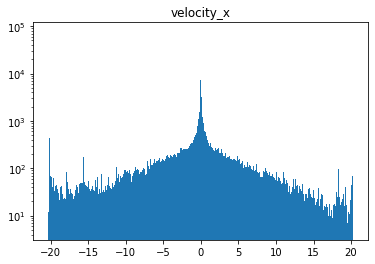

In [9]:

plot_hist(sdf, 'velocity_x', 1000);

22/12/15 18:07:04 WARN TaskSetManager: Stage 4 contains a task of very large size (1140 KiB). The maximum recommended task size is 1000 KiB.
22/12/15 18:07:05 WARN TaskSetManager: Stage 5 contains a task of very large size (1140 KiB). The maximum recommended task size is 1000 KiB.


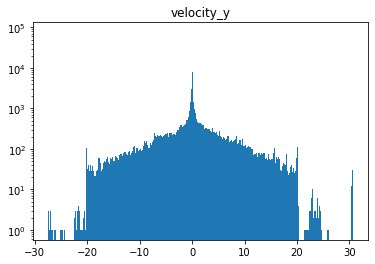

In [10]:
plot_hist(sdf, 'velocity_y', 1000);

22/12/15 18:07:10 WARN TaskSetManager: Stage 6 contains a task of very large size (1140 KiB). The maximum recommended task size is 1000 KiB.
22/12/15 18:07:10 WARN TaskSetManager: Stage 7 contains a task of very large size (1140 KiB). The maximum recommended task size is 1000 KiB.


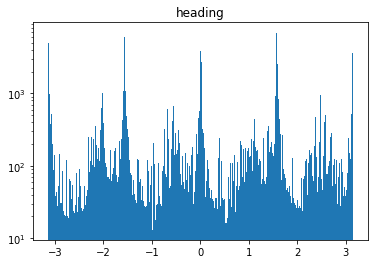

In [11]:
plot_hist(sdf, 'heading', 1000);

22/12/15 18:07:15 WARN TaskSetManager: Stage 8 contains a task of very large size (1140 KiB). The maximum recommended task size is 1000 KiB.
22/12/15 18:07:15 WARN TaskSetManager: Stage 9 contains a task of very large size (1140 KiB). The maximum recommended task size is 1000 KiB.


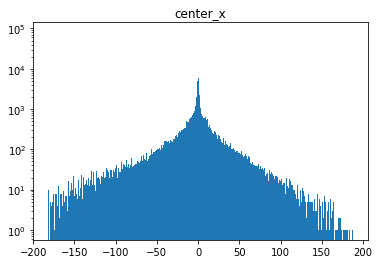

In [12]:
plot_hist(sdf, 'center_x', 1000);

22/12/15 18:07:20 WARN TaskSetManager: Stage 10 contains a task of very large size (1140 KiB). The maximum recommended task size is 1000 KiB.
22/12/15 18:07:21 WARN TaskSetManager: Stage 11 contains a task of very large size (1140 KiB). The maximum recommended task size is 1000 KiB.


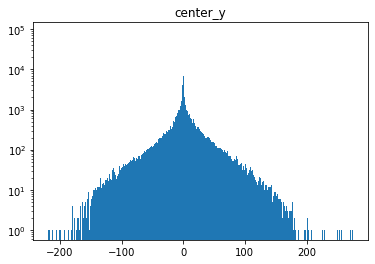

In [13]:
plot_hist(sdf, 'center_y', 1000);

In [ ]:
# TODO:
"""
 - hist(state, distante, valid)
    - heading
    - velocity 
    - 
 - track-uri suprapuse
 - speed_limit_mph
 - hist pe lane types https://github.com/waymo-research/waymo-open-dataset/blob/master/waymo_open_dataset/protos/map.proto#L146
 - stop sign 

 - free ahead
 - chaning lanes
 - TrafficSignalLaneState https://github.com/waymo-research/waymo-open-dataset/blob/master/waymo_open_dataset/protos/map.proto
 - conditionare pe train/validation
"""

# DONE
"""
 - object type distribution
"""

In [41]:
scenario = scenarios[0]
t = scenario.tracks[0]
scenario.tracks[scenario.sdc_track_index]

id: 685
object_type: TYPE_VEHICLE
states {
  center_x: 1013.7763858920335
  center_y: -1990.6604455216343
  center_z: -21.540703516633386
  length: 5.285999774932861
  width: 2.3320000171661377
  height: 2.3299999237060547
  heading: 1.1018315553665161
  velocity_x: 1.968289852142334
  velocity_y: 3.540196418762207
  valid: true
}
states {
  center_x: 1013.9729557334946
  center_y: -1990.3123723802473
  center_z: -21.541616171834413
  length: 5.285999774932861
  width: 2.3320000171661377
  height: 2.3299999237060547
  heading: 1.0895609855651855
  velocity_x: 1.9535174369812012
  velocity_y: 3.4060587882995605
  valid: true
}
states {
  center_x: 1014.1677965447275
  center_y: -1989.9780004665793
  center_z: -21.54369392215824
  length: 5.285999774932861
  width: 2.3320000171661377
  height: 2.3299999237060547
  heading: 1.0786244869232178
  velocity_x: 1.9251240491867065
  velocity_y: 3.270656108856201
  valid: true
}
states {
  center_x: 1014.3585918653223
  center_y: -1989.657201290